# Практика

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
import statsmodels.stats.weightstats as ssw

## ЦПТ для различных распределений
Возьмите то непрерывное распределение, которое вам больше всего понравится из списка доступных в модуле [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html).

### Сгенерируйте примеры из распределения

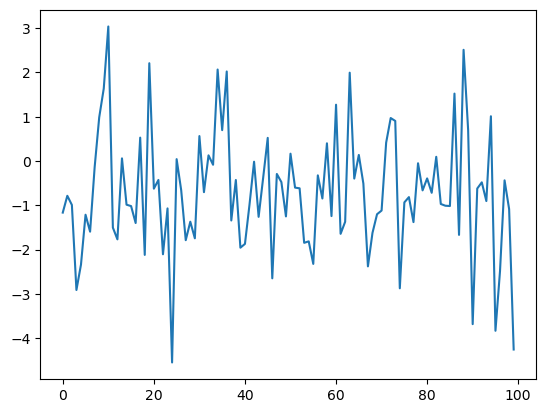

In [2]:
test_rv = sts.laplace(loc=-1)
test_sample = test_rv.rvs(100)
sns.lineplot(data=test_sample);

In [3]:
real_mean = test_rv.mean() # настоящее среднее случайной величины
real_var = test_rv.var() # настоящая дисперсия случайной величины

print(f'real_mean={real_mean}, real_var={real_var}')

real_mean=-1.0, real_var=2.0


### Постройте гистограмму выборки и теоретическую плотность распределения

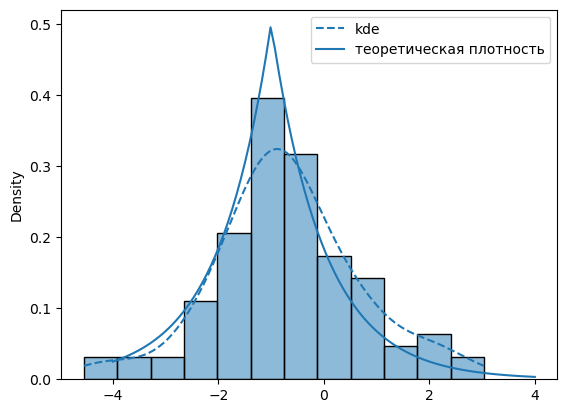

In [4]:
sns.histplot(test_sample, stat='density', kde=True, line_kws={'label': 'kde', 'linestyle': '--'})

x = np.linspace(-4, 4, 100)
sns.lineplot(x=x, y=test_rv.pdf(x), label='теоретическая плотность');

In [5]:
sample_mean = test_sample.mean() # выборочное среднее
sample_var = test_sample.var() # выборочная дисперсия
print(f'sample_mean={sample_mean:.6f}, sample_var={sample_var:.6f}')

sample_mean=-0.714218, sample_var=1.908889


### Оценим распределение выборочного среднего для разных объёмов выборок
Для этого постройте на одном полотне гистограмму выборочных средних и теоретическое распределение выборочных средних по ЦПТ для разных объёмов выборок.

Для теоретического распределение используйте настоящие значения мат ожидания и дисперсии (не приближенные на основе выборки).

In [6]:
N = [10, 100, 1000, 10000] # размеры выборок
M = 1000 # количество повторений

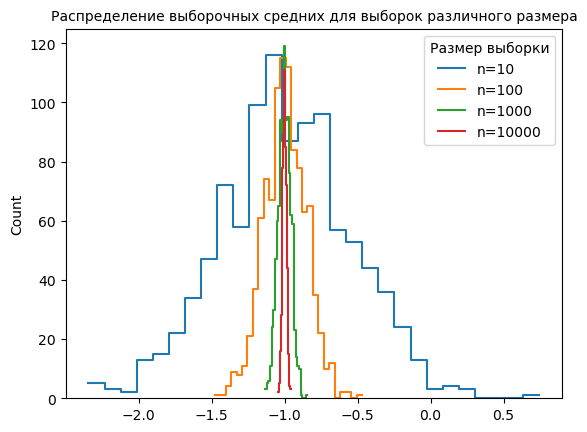

In [7]:
for n in N:
    means = [test_rv.rvs(n).mean() for _ in range(M)]
    sns.histplot(means, element='step', fill=False, label=f'n={n}')
plt.title('Распределение выборочных средних для выборок различного размера', fontsize=10)
plt.legend(title='Размер выборки');

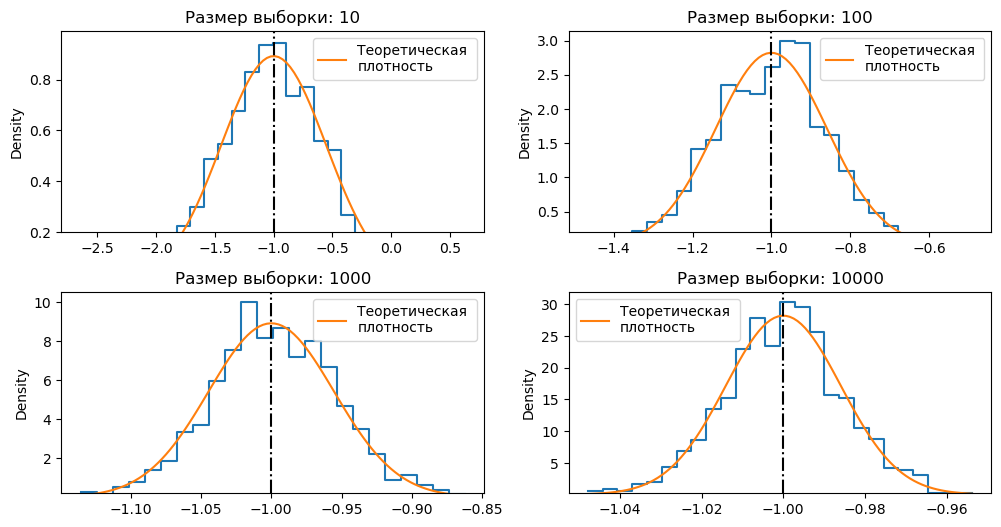

In [8]:
_, ax = plt.subplots(2, 2, figsize=(12, 6))
ax = ax.flatten()
plt.subplots_adjust(hspace=0.3)

for i, n in enumerate(N):
    norm_rv = sts.norm(loc=test_rv.mean(), scale=test_rv.std() / np.sqrt(n))
    test_means = np.array([test_rv.rvs(n).mean() for _ in range(M)])
    sns.histplot(x=test_means, stat='density', element='step', fill=False, ax=ax[i])
    x = np.linspace(test_means.min(), test_means.max(), 100)
    sns.lineplot(x=x, y=norm_rv.pdf(x), label='Теоретическая \nплотность', ax=ax[i])
    ax[i].axvline(real_mean, c='k', linestyle='-.')
    ax[i].set(title=f'Размер выборки: {n}', ybound=0.2)

Как вы считаете, для выбранного распределения апроксимация распределения выборочного среднего работает хорошо или плохо?

**Ваш ответ:**
* при увеличении размера выборки гистограммы становятся плотнее к истинному среднему значению (-1)
* распределения выборочных средних для выбранного распределения (Лапласа) хорошо апроксимируются нормальным распределением с параметрами: $$N \left( E_{laplace}, \sqrt \frac {D_{laplace}} {n} \right)$$

## Доверительный интервал на основе ЦПТ
Возьмите данные для оттока телеком компании, и постройте доверительные интервалы для среднего значения total day calls, используя центральную предельную теорему в разбиении по колонке churn (ушел/не ушел). 

Для оценки дисперсии используйте несмещенную оценку (параметр ddof=1).

Сделайте оценку с использованием явной формулы для z интервала, а затем с помощью функций 
`from statsmodels.stats.weightstats import _zconfint_generic`. Сравните результаты.


Ссылка на данные: https://drive.google.com/file/d/1X_drKqoarnU2Sz2har7uSCsgyhh8Xtz8/view?usp=sharing

In [9]:
# либо загружаем из альтернативного хранилища
url ="https://raw.githubusercontent.com/piton1/DS/Lesson_5/telecom_churn.csv"
df=pd.read_csv(url)
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


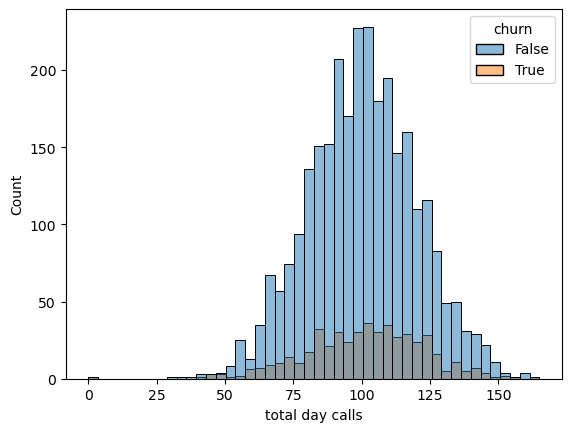

In [10]:
sns.histplot(data=df, x='total day calls', hue='churn');

In [11]:
def explicit_conf_95(dat):
    lo = dat.mean() - 1.96 * dat.std(ddof=1) / np.sqrt(len(dat) - 1)
    hi = dat.mean() + 1.96 * dat.std(ddof=1) / np.sqrt(len(dat) - 1)
    return lo, hi

def wstat_conf_95(dat):
    return ssw._zconfint_generic(dat.mean(),  dat.std(ddof=1), alpha=0.95, alternative='two-sided')

res = df.groupby('churn').agg({'total day calls': [explicit_conf_95, wstat_conf_95]}).stack()
res

total day calls
churn                                                          
False explicit_conf_95  (99.55604740026513, 101.01026838920856)
      wstat_conf_95     (99.04149114274126, 101.52482464673243)
True  explicit_conf_95  (99.40863130099713, 103.26217615241903)
      wstat_conf_95     (99.98204678079553, 102.68876067262063)

In [12]:
print('95% доверительный интервал для ушедших клиентов (по ЦПТ):')
print(f"\tявная формула для z-интервала: {res.xs((True, 'explicit_conf_95'))[0]}")
print(f"\tфункция _zconfint_generic: {res.xs((True, 'wstat_conf_95'))[0]}")

print('95% доверительный интервал для оставшихся клиентов (по ЦПТ):')
print(f"\tявная формула для z-интервала: {res.xs((False, 'explicit_conf_95'))[0]}")
print(f"\tфункция _zconfint_generic: {res.xs((False, 'wstat_conf_95'))[0]}")

95% доверительный интервал для ушедших клиентов (по ЦПТ):
	явная формула для z-интервала: (99.40863130099713, 103.26217615241903)
	функция _zconfint_generic: (99.98204678079553, 102.68876067262063)
95% доверительный интервал для оставшихся клиентов (по ЦПТ):
	явная формула для z-интервала: (99.55604740026513, 101.01026838920856)
	функция _zconfint_generic: (99.04149114274126, 101.52482464673243)


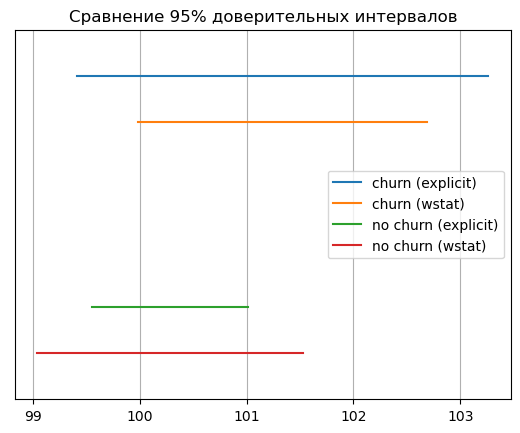

In [13]:
plt.plot(res.xs((True, 'explicit_conf_95'))[0], [4, 4], label='churn (explicit)')
plt.plot(res.xs((True, 'wstat_conf_95'))[0], [3.5, 3.5], label='churn (wstat)')
plt.plot(res.xs((False, 'explicit_conf_95'))[0], [1.5, 1.5], label='no churn (explicit)')
plt.plot(res.xs((False, 'wstat_conf_95'))[0], [1, 1], label='no churn (wstat)')
plt.legend(loc='center right')
plt.ylim([0.5, 4.5])
plt.yticks([])
plt.grid(axis='x')
plt.title('Сравнение 95% доверительных интервалов');

**Выводы:**
* доверительный интервал для ушедших клиентов шире чем у оставшихся, а также смещен в сторону больших значений
* сравнение результатов расчетов по явной формуле и `_zconfint_generic` неоднозначное (последняя диаграмма):
  * для ушедших клиентов метод `_zconfint_generic` выдал более узкий интервал
  * для оставшихся явная формула выдала более узкий интервал